In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Insert the directory
import sys
sys.path.insert(0,"/content/drive/My Drive/TSOAI/S6")

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
#from model import Net
from model import Train,NetBatchNorm,NetDilated,ResNet
from utils import display_model_summary,calculate_mean_std,imshow,im_convert,im_convert_numpy,find_misclassified_images,display_missclassfied_images,display_images
from dataset import Cifar10Dataset,DataTransformation
import numpy as np
import torchvision
import albumentations
import albumentations as A
import albumentations.pytorch
from albumentations.pytorch import ToTensorV2

In [ ]:
mean,std = calculate_mean_std("CIFAR10")

100%|██████████| 170498071/170498071 [00:13<00:00, 12806860.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
data_transformation = DataTransformation(mean,std)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:133: FutureWarning: IAAFliplr is deprecated. Please use HorizontalFlip instead.
  warnings.warn("IAAFliplr is deprecated. Please use HorizontalFlip instead.", FutureWarning)


In [ ]:
train = Cifar10Dataset(transform=data_transformation.train)
test = Cifar10Dataset(train=False,transform=data_transformation.test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
params = {
    "model": "cifar10dilated",
    "seed":1,
    "lr": 0.1,
    "batch_size": 512,
    "num_workers": 4,
    "epochs": 24,
}

In [ ]:
#SEED = 1

# CUDA?

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(params["seed"])


if cuda:
    torch.cuda.manual_seed(params["seed"])

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=params["batch_size"], num_workers=params["num_workers"], pin_memory=True) if cuda else dict(shuffle=True, batch_size=params["batch_size"])

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


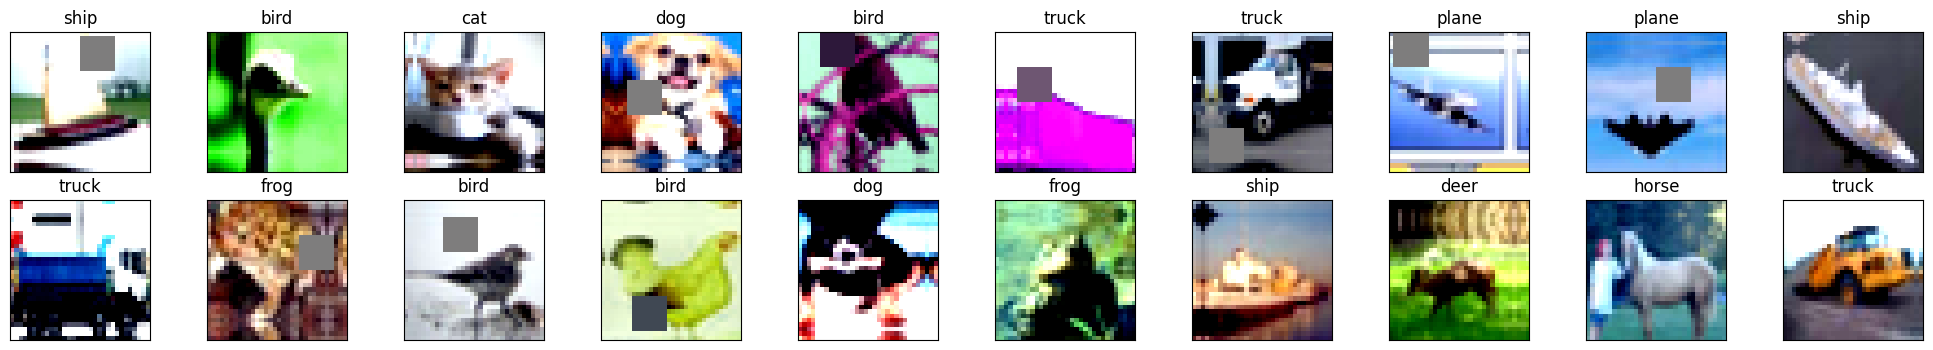

In [ ]:
# We iter the batch of images to display
dataiter = iter(train_loader) # converting our train_dataloader to iterable so that we can iter through it.
images, labels = next(dataiter) #going from 1st batch of 4 images to the next batch
#print(images[0].shape)
display_images(images,labels,20,classes)

PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]

Layer1 -
X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]
R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k]
Add(X, R1)

Layer 2 -
Conv 3x3 [256k]
MaxPooling2D
BN
ReLU

Layer 3 -
X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]
R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]
Add(X, R2)

MaxPooling with Kernel Size 4
FC Layer
SoftMax

In [ ]:
from collections import OrderedDict
class ResidualBlock(nn.Module):
  def __init__(self,in_channel,kernel_size,stride,padding,identity_down_sample = None, normType="BN"):
    super(ResidualBlock,self).__init__()
    self.expansion = 1
    self.block = nn.Sequential(nn.Conv2d(in_channels=in_channel,out_channels=in_channel*self.expansion,kernel_size=kernel_size,stride=stride,padding=padding,bias=False),
                               nn.BatchNorm2d(in_channel*self.expansion),
                               nn.ReLU()
                               )
    self.identity_down_sample = identity_down_sample



  def forward(self,x):
    identity = x
    x = self.block(x)
    if self.identity_down_sample !=None:
      pass
    x = x + identity
    return x




In [ ]:
ab = ResidualBlock(3,64,3,1,0)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
# instantiate the model and load it to the device
model = ResNet().to(device)
#model structure
display_model_summary(model,input_structure=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

In [ ]:
!pip install torch-lr-finder
from torch_lr_finder import LRFinder

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.15E-02


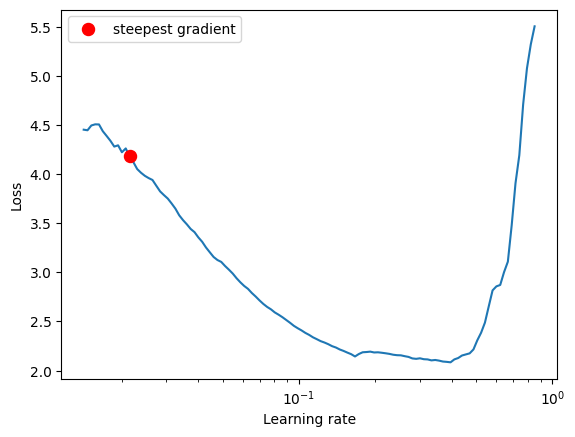

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR
scheduler = OneCycleLR(
        optimizer,
        max_lr=2.83E-02,
        steps_per_epoch=len(train_loader),
        epochs=params["epochs"],
        pct_start=5/params["epochs"],
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

In [ ]:
train_instance = Train(model,device,criterion,optimizer,scheduler,train_loader,test_loader,num_epochs=params["epochs"],batch_size=params["batch_size"])

In [ ]:
train_instance()

epoch : 1
training loss: 0.0028, acc 48.72% 
validation loss: 0.0019, validation acc 67.15% 
epoch : 2
training loss: 0.0019, acc 66.73% 
validation loss: 0.0017, validation acc 71.10% 
epoch : 3
training loss: 0.0017, acc 71.03% 
validation loss: 0.0013, validation acc 78.13% 
epoch : 4
training loss: 0.0014, acc 74.94% 
validation loss: 0.0012, validation acc 79.69% 
epoch : 5
training loss: 0.0014, acc 76.48% 
validation loss: 0.0012, validation acc 79.54% 
epoch : 6
training loss: 0.0012, acc 78.23% 
validation loss: 0.0011, validation acc 81.60% 
epoch : 7
training loss: 0.0012, acc 79.68% 
validation loss: 0.0011, validation acc 81.10% 
epoch : 8
training loss: 0.0011, acc 80.50% 
validation loss: 0.0010, validation acc 83.93% 
epoch : 9
training loss: 0.0011, acc 80.89% 
validation loss: 0.0009, validation acc 83.97% 
epoch : 10
training loss: 0.0011, acc 81.64% 
validation loss: 0.0009, validation acc 84.52% 
epoch : 11
training loss: 0.0010, acc 82.41% 
validation loss: 0.0009

In [ ]:
def display_max_min_lr(data):
  print("Max LR ",np.max(train_instance.step_to_lr))
  print("Min LR",np.min(train_instance.step_to_lr))

In [ ]:
display_max_min_lr(train_instance.step_to_lr)

Max LR  0.0283
Min LR 2.8299999999988057e-06


In [ ]:
def display_graph(data,label="Learning Rate Variation"):
  plt.style.use('ggplot')
  plt.plot(data,label=label)
  plt.legend()

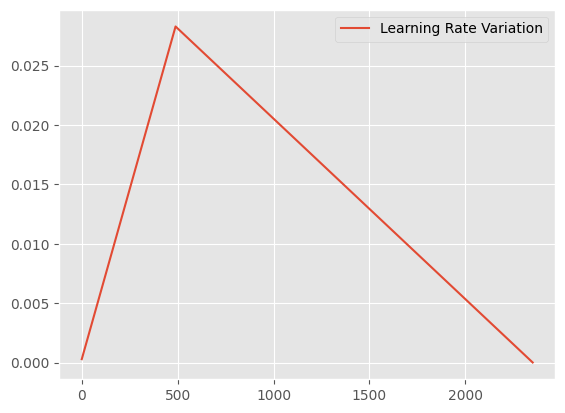

In [ ]:
display_graph(train_instance.step_to_lr)

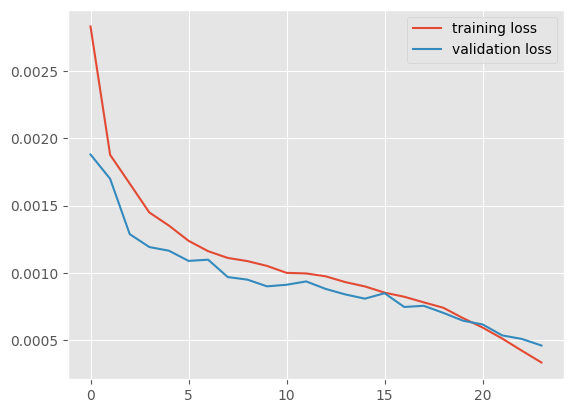

In [ ]:
plt.style.use('ggplot')
plt.plot(train_instance.running_loss_history, label='training loss')
plt.plot(train_instance.val_running_loss_history, label='validation loss')
plt.legend()

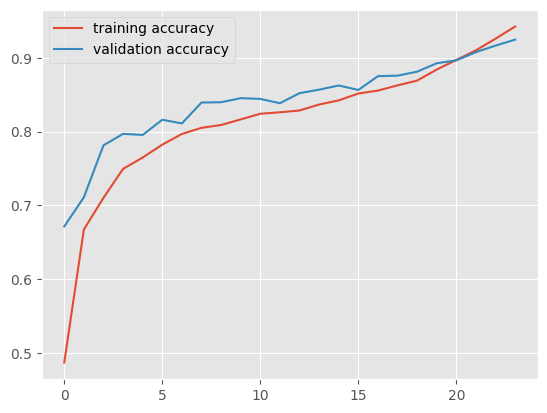

In [ ]:
plt.style.use('ggplot')
plt.plot([i.cpu().detach().numpy() for i in train_instance.running_corrects_history], label='training accuracy')
plt.plot([i.cpu().detach().numpy() for i in train_instance.val_running_corrects_history], label='validation accuracy')
plt.legend()

In [ ]:
misclassified_images,misclassified_labels,true_labels=find_misclassified_images(15,test_loader,device,model)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<Figure size 2500x400 with 0 Axes>

TypeError: ignored

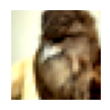

In [ ]:
display_missclassfied_images(misclassified_images,classes)